# RUN PERFORMANCE PROJECT - Pau Sampietro

## Data Exploratory Analysis & Visualization 

In this file we start doing some explorations over the data, performing some statistical analysis and giving some insights based on results and explanatory plots.
Some of the hypothesis that we will demonstrate are: 
 * Pace in track (min/km) is normally distributted for a given period of time. (Goodness of fit)
 * Comparison between Athletes: ***Armand*** is significantly faster than ***Pau***
 * The longer the run, the slower the pace
 * The more accumulated ascent, the higher heart rate
    
1. Descriptive statistics
2. Explanatory plots and interactive visualizations
3. Hypothesis testing, if needed

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, export_table

## Import Data from the Google Cloud Database

We start importing the "moves" table, in order to perform some exploratory analysis of the moves.

In [5]:
moves = read_table('moves')

* We split the data in two dataframes in order to perform some separated analysis of both runners. We are also taking out two outliers (100k and 100M races from Armand)

In [91]:
moves_p = moves[moves.athlete == 'P']

In [177]:
moves_a = moves[(moves.athlete == 'A') & moves.distance < 6e4]

## ***Moves.***  Descriptive Statistics & Visualizations

General descriptive Statistics for both athletes

In [178]:
moves_p.describe()

,index,move,distance,calories,accum_ascent,moving_time,pace
count,143.00000,143.00000,143.00000,143.000000,143.000000,143.000000,143.000000
mean,71.00000,72.00000,8530.27972,902.181818,232.693706,55.318182,6.357552
std,41.42463,41.42463,5583.40196,694.950304,279.333046,49.949325,3.031557
min,0.00000,1.00000,518.00000,46.000000,0.600000,3.400000,4.380000
25%,35.50000,36.50000,6014.00000,545.500000,101.700000,31.800000,5.340000
50%,71.00000,72.00000,7064.00000,711.000000,136.200000,39.700000,5.700000
75%,106.50000,107.50000,10056.50000,968.500000,241.700000,59.150000,6.440000
max,142.00000,143.00000,37196.00000,4097.000000,1452.200000,321.000000,36.440000


In [179]:
moves_a.describe()

,index,move,distance,calories,accum_ascent,moving_time,pace
count,813.000000,813.000000,813.000000,805.000000,813.000000,813.000000,813.000000
mean,406.000000,409.403444,11565.228782,980.472050,272.048462,65.041574,5.649705
std,234.837178,236.370080,9706.896844,913.117682,436.308980,71.739980,2.591408
min,0.000000,1.000000,29.000000,0.000000,0.000000,0.700000,3.560000
25%,203.000000,205.000000,6043.000000,511.000000,75.000000,32.100000,4.820000
50%,406.000000,409.000000,10026.000000,778.000000,160.000000,51.700000,5.110000
75%,609.000000,614.000000,14459.000000,1222.000000,325.400000,78.500000,5.580000
max,812.000000,817.000000,159600.000000,15485.000000,7922.600000,1357.400000,48.280000


### 1. Normal Distribution (Goodness of Fit) for variable: Pace (min/km)

We generate two new series with the paces for both athletes:

In [180]:
pace_p = moves_p['pace'][(moves_p.pace > 3) & (moves_p.pace < 8)]
pace_a = moves_a['pace'][(moves_a.pace > 3) & (moves_a.pace < 8)]

By applying the Kolmogorov-Smirnov test for goodness of fit, here we are checking if it is possible to model our data with some continuous distributions:

In [181]:
# Distributions to check with KS test.
dist_list = ['norm', 't', 'lognorm', 'expon', 'pareto']

# Checking the goodness of fit for every distribution in both athletes
for ath in [['Pau', pace_p], ['Armand', pace_a]]:
    print(f'Goodness of fit results for {ath[0]}:')
    for dist_name in dist_list:
        dist = getattr(stats, dist_name)
        param = dist.fit(ath[1])
        stat, p_value = stats.kstest(ath[1], dist_name, args = param)
        print(f'* Distribution: {dist_name} (KS statistic = {round(stat, 5)} , p_value = {round(p_value, 5)})')
    print('\n')

Goodness of fit results for Pau:
* Distribution: norm (KS statistic = 0.0922 , p_value = 0.21332)
* Distribution: t (KS statistic = 0.06613 , p_value = 0.62521)
* Distribution: lognorm (KS statistic = 0.05797 , p_value = 0.78296)
* Distribution: expon (KS statistic = 0.24242 , p_value = 0.0)
* Distribution: pareto (KS statistic = 0.26536 , p_value = 0.0)


Goodness of fit results for Armand:
* Distribution: norm (KS statistic = 0.12946 , p_value = 0.0)
* Distribution: t (KS statistic = 0.07553 , p_value = 0.0003)
* Distribution: lognorm (KS statistic = 0.07435 , p_value = 0.00039)
* Distribution: expon (KS statistic = 0.38237 , p_value = 0.0)
* Distribution: pareto (KS statistic = 0.41361 , p_value = 0.0)




As we could see in the cell above, the results for the KS test for goodness of fit are much more better for Pau's data. That means that ***the pace of Pau's moves could be better explained with a normal, a t-student or even a lognorm distribution***, based on the ***p_value***, which is higher than 0.05 in all this 3 tests. On the other hand, ***Armand's paces are not well explained by any of these distributions***, maybe because paces of cross-country and track are significantly different, and both are included in the same data.

* Checking only Armand's moves arround the mean distance (11.5k)

In [182]:
moves_a_11 = moves_a[(moves_a.distance > 10000) & (moves_a.distance < 12000)]

*For Armand moves arround 11k: KS statistic = 0.9999784313405519, p_value = 0.0


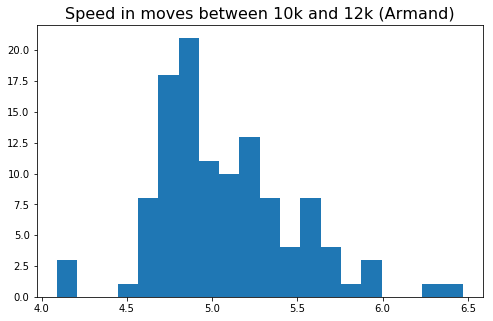

In [183]:
plt.figure(figsize=(8,5))
plt.hist(moves_a_11['pace'][moves_a_11.pace < 7], bins=20)
plt.title('Speed in moves between 10k and 12k (Armand)', fontsize =16)
stat, p_value = stats.kstest(moves_a_11['pace'], 'norm')
print(f'*For Armand moves arround 11k: KS statistic = {stat}, p_value = {p_value}')

Trying to focus the analysis only in the "standard runs", which are arround the mean distance (10-12k) we also note that the data is not well represented by a normal distribution. Some things that could be affecting our results are:
* including moves with a much slower pace (probably recovery runs or cross-country with high ascent)
* including moves with a really fast pace (arround 4 min/km), probably they are speed series.

###  2. Pace, distance and ascent comparison

#### 2.1. Distance (m) and moving time (min) interactive visualization

In [184]:
cf.go_offline()
trace_p = go.Scatter(
    x=moves['distance'][moves.athlete == 'P'],
    y=moves['moving_time'][moves.athlete == 'P'],
    mode='markers',
    marker=dict(size=12,
                line=dict(width=1),
                color='turquoise'
               ),
    name="Pau's moves"
    )
trace_a = go.Scatter(
    x=moves['distance'][moves.athlete == 'A'],
    y=moves['moving_time'][moves.athlete == 'A'],
    mode='markers',
    marker=dict(size=12,
                line=dict(width=1),
                color='orange'
               ),
    name="Armand's moves",
    )
data_comp = [trace_p, trace_a]

layout_comp = go.Layout(
    title="Distance vs Moving time for both athletes",
    hovermode='closest',
    xaxis=dict(
        title='distance (m)',
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='moving time (min)',
        ticklen=5,
        gridwidth=2,
    ),
)
fig_comp = go.Figure(data=data_comp, layout=layout_comp)
fig_comp.iplot(filename='ap3')

As the athletes are amateur, we can se that most of the training runs are arround 10k, almost all of them under 30k, few of them are long distance runs and there are also two outliers corresponding to a 100k and 100M races in USA.
We could also appreciate that Armand is training much more frequently than Pau, according to the proportion of both series ***(~500 moves vs. ~150 moves per year)***

#### 2.2. General pace comparison between both athletes

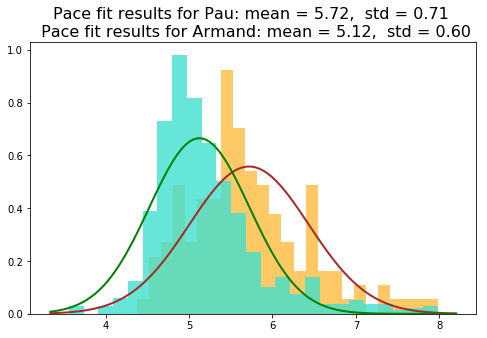

In [185]:
# Fitting a normal distribution to the data:
mu_p, std_p = stats.norm.fit(data_p)
mu_a, std_a = stats.norm.fit(data_a)

# Plotting Histograms for both Pau and Armand pacing
plt.figure(figsize=(8,5))
plt.hist(pace_p, bins = 25, density=True, alpha=0.6, color='orange')
plt.hist(pace_a, bins = 25, density=True, alpha=0.8, color='turquoise')

#Plotting normal distributions (PDF)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_p = stats.norm.pdf(x, mu_p, std_p)
p_a = stats.norm.pdf(x, mu_a, std_a)
plt.plot(x, p_p, 'k', linewidth=2, color = 'brown')
plt.plot(x, p_a, 'k', linewidth=2, color = 'green')

title = """Pace fit results for Pau: mean = %.2f,  std = %.2f \n Pace fit results for Armand: mean = %.2f,  std = %.2f""" % (mu_p, std_p, mu_a, std_a)
plt.title(title, fontsize = 16)
plt.show()


In this plot we can see that, althought KS test says that Armand's speed is not well explained by a normal dist., if we fit a normal distribution for each athlete, we can appreciate that the mean of his moves is lower, and so the standard deviation also.

#### 2.3. Analysis of the accumulated ascent and the slope.

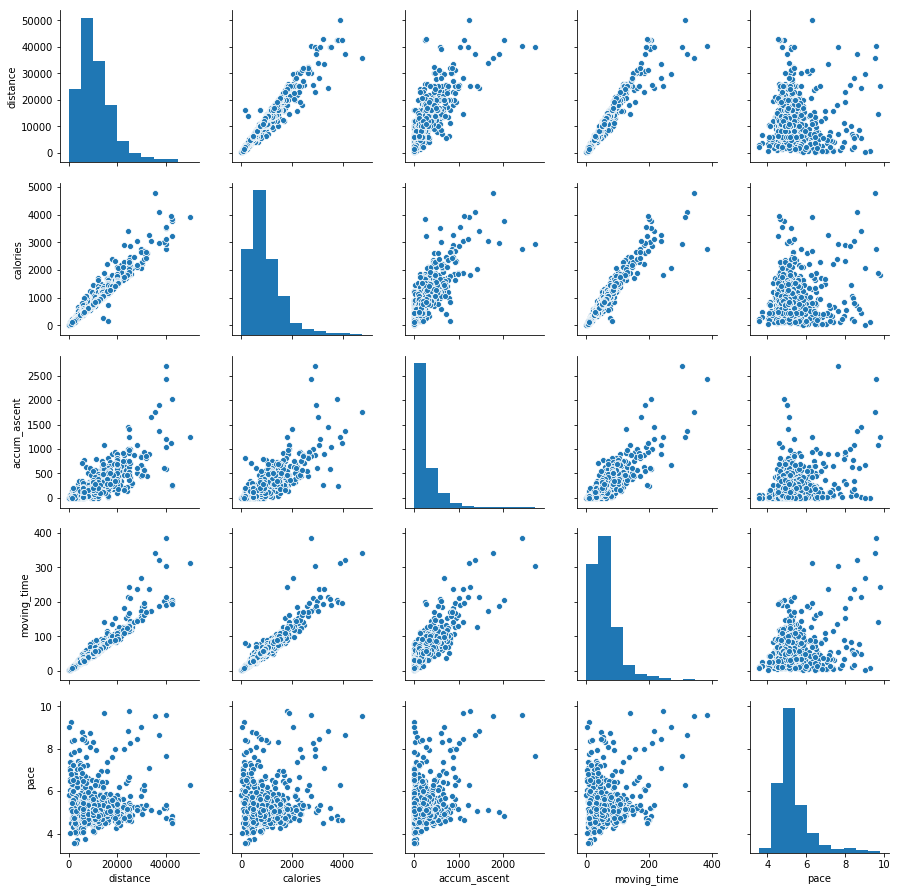

In [191]:
sns.pairplot(moves[(moves.distance < 6e4) & (moves.pace < 10)].drop(columns=['index','move'], axis = 1))

confidence intervals: loc= mean, scale = std

In [ ]:
stats.norm.interval(0.95, loc=0, scale=1)

one sample test

In [ ]:
# Your code here:
# Ho : are 30$/dollar
# H1 : not really

from scipy.stats import ttest_1samp

stat, p = ttest_1samp(salaries['Hourly Rate'][ salaries['Hourly Rate'].isnull() == False],30)
p

function to perform 2 sample test in many features

In [ ]:
def t_test_features(s1, s2, features=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']):
    """Test means of a feature set of two samples
    
    Args:
        s1 (dataframe): sample 1
        s2 (dataframe): sample 2
        features (list): an array of features to test
    
    Returns:
        dict: a dictionary of t-test scores for each feature where the feature name is the key and the p-value is the value
    """
    results = {}

    # Your code here
    
    return results

We can conduct ANOVA test if std of armands move and paus moves are equal.